In [1]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import gaussian_filter1d
from scipy.stats import landau

FADC_BIN_WIDTH = 2


In [2]:
def load_pmt(input_file,pmtname, minnpe = 0.): 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    pmt_em = data.query("id == 1 or id == 2 or id == -2")[pmtname]
    pmt_mu = data.query("id == 3 or id == -3")[pmtname]

    pmt_mu = np.asarray(pmt_mu[pmt_mu >= minnpe])
    pmt_em = np.asarray(pmt_em[pmt_em >= minnpe])
    pmt_tot = np.concatenate((pmt_mu,pmt_em))
    
    return pmt_tot

def load_top_sum_fadc_pmt(input_file, minnpe = 0.): 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    pmt_em_1 = data.query("id == 1 or id == 2 or id == -2")['pmt1_FADC']
    pmt_mu_1 = data.query("id == 3 or id == -3")['pmt1_FADC']
    pmt_em_2 = data.query("id == 1 or id == 2 or id == -2")['pmt2_FADC']
    pmt_mu_2 = data.query("id == 3 or id == -3")['pmt2_FADC']
    pmt_em_3 = data.query("id == 1 or id == 2 or id == -2")['pmt3_FADC']
    pmt_mu_3 = data.query("id == 3 or id == -3")['pmt3_FADC']

    pmt_mu_1 = np.asarray(pmt_mu_1[pmt_mu_1 >= minnpe])
    pmt_em_1 = np.asarray(pmt_em_1[pmt_em_1 >= minnpe])
    pmt_tot_1 = np.concatenate((pmt_mu_1,pmt_em_1))

    pmt_mu_2 = np.asarray(pmt_mu_2[pmt_mu_2 >= minnpe])
    pmt_em_2 = np.asarray(pmt_em_2[pmt_em_2 >= minnpe])
    pmt_tot_2 = np.concatenate((pmt_mu_2,pmt_em_2))

    pmt_mu_3 = np.asarray(pmt_mu_3[pmt_mu_3 >= minnpe])
    pmt_em_3 = np.asarray(pmt_em_3[pmt_em_3 >= minnpe])
    pmt_tot_3 = np.concatenate((pmt_mu_3,pmt_em_3))

    pmt_tot = np.concatenate((pmt_tot_1, pmt_tot_2, pmt_tot_3))
    
    return pmt_tot

In [3]:

# Gaussian function for fitting
def gaussian(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def landau_func(x, A, mu, sigma): 
    return A * landau.pdf(x,mu,sigma)


# Define funciton to perform Gaussian fit of the peak 
fadc_bins = np.arange(0,1000,1)

def gaussian_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('FADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins)
    sigma_entries_fit = np.sqrt(entries_fit)
    sigma_entries_fit[sigma_entries_fit == 0] = 1e-6  # avoid zero division

    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for Gaussian parameters 
    p0 = [max(array_to_fit), np.mean(array_to_fit), 2.5*np.std(array_to_fit)]
    print('First guess ',p0)
    bounds = ([0, -np.inf, 1e-6], [np.inf, np.inf, np.inf])

    #array_to_fit = input_array[(input_array > 1.5*np.std(array_to_fit)) & (input_array < 2.5*np.std(array_to_fit))]

    #popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0, bounds = bounds, sigma = sigma_entries_fit, absolute_sigma=True)
    popt, pcov = curve_fit(landau_func, bin_centers, entries_fit, p0=p0)

    # Extract parameter estimates
    A_fit, mu_fit, sigma_fit = popt

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))
    A_err, mu_err, sigma_err = perr


    return popt, perr, range 


In [4]:
# Function to find minumum in a range defined by a lower limit and the peak maximum 

def find_valley(input_array, low_threshold, peak_position): 
    print('Looking for minimum between ',low_threshold,' and ', peak_position)
    array_formin = input_array[(input_array >low_threshold) & (input_array < peak_position)]

    bins = np.arange(low_threshold+2, int(peak_position),FADC_BIN_WIDTH)

    entries, bin = np.histogram(array_formin, bins=bins)
    fadc_min = np.argmin(entries)
    return bin[fadc_min]


In [10]:
pmt_tot = load_pmt('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/top_40cm_3',"pmt4_FADC", minnpe=0)
len(pmt_tot[pmt_tot > 0])

20840

FADC bin with largest entries  532
First guess  [np.int64(631), np.float64(544.5332244897959), np.float64(112.40205935734346)]
Result of Gaussian fit
A = 14958.809835825941  +- 313.58123229524847
mu = 529.7464829510861  +- 1.2725780055962175
sigma = 41.01694149844979  +- 1.129479407756058
Looking for minimum between  150  and  529.7464829510861
Found minimum at  246 

FADC bin with largest entries  484
First guess  [np.int64(583), np.float64(500.25875723423695), np.float64(111.8153915193716)]
Result of Gaussian fit
A = 16328.786503315157  +- 361.29185122591974
mu = 488.3868215421878  +- 1.4288465730904936
sigma = 43.628442277930525  +- 1.268065887999604
Looking for minimum between  150  and  488.3868215421878
Found minimum at  220 

FADC bin with largest entries  466
First guess  [np.int64(565), np.float64(480.91132017273287), np.float64(111.22796003105408)]
Result of Gaussian fit
A = 16078.993286506231  +- 344.83018039766876
mu = 468.54393422079556  +- 1.3624472002890156
sigma = 42.91

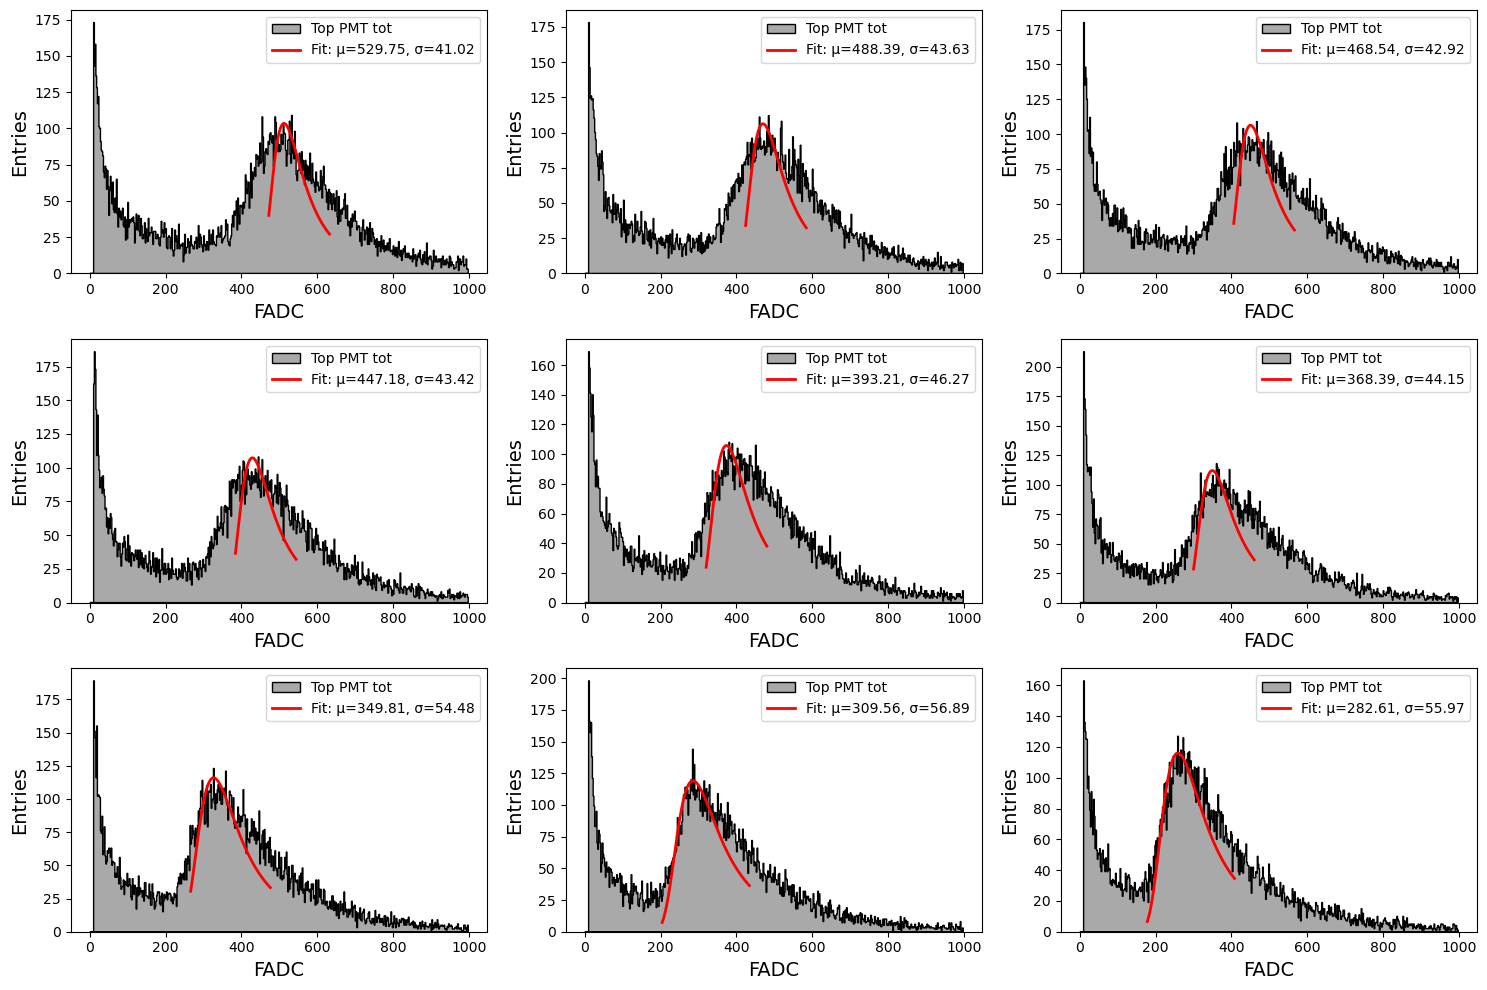

In [21]:
input_folder = '/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/'
input_files = ['top_30cm_3', 'top_35cm_3', 'top_40cm_3', 'top_45cm_3', 'top_50cm_3', 'top_55cm_3', 'top_60cm_3', 'top_65cm_3','top_70cm_3']

min_npe = 10.

plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,1000,FADC_BIN_WIDTH)
fadc_bin_centers = (fadc_bins_fit[:-1] + fadc_bins_fit[1:]) / 2.

low_count_threshold_array = [200, 200, 200, 200, 200, 200, 200, 200, 200]
low_count_threshold_array_min = [150, 150, 150, 150, 150, 150, 150, 150, 150]

range_width_low = [60, 60, 60, 60, 60, 60, 60, 80, 80]
range_width_hi = [100, 100, 100, 100, 100, 100, 150, 150, 150]

fadc_peak_bin = np.zeros(len(input_files))
rel_peak_err = np.zeros(len(input_files))
fadc_peak_entries = np.zeros(len(input_files))

fadc_min_bin = np.zeros(len(input_files))
fadc_min_entries = np.zeros(len(input_files))

for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_pmt(input_folder+file,"pmt4_FADC", minnpe=10)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    par, d_par, range = gaussian_fit(pmt_tot, fadc_bins_fit, range_low=range_width_low[i], range_hi=range_width_hi[i], low_count_threshold=low_count_threshold_array[i])
    A_fit, mu_fit, sigma_fit = par
    A_err, mu_err, sigma_err = d_par

    # Compute fitted curve
    x_fit = np.linspace(range[0], range[1], 1000)
    y_fit = landau_func(x_fit, *par)

    print('Result of Gaussian fit')

    print('A =',A_fit,' +-',A_err)
    print('mu =',mu_fit,' +-',mu_err)
    print('sigma =',sigma_fit,' +-',sigma_err)

    rel_peak_err[i] = mu_err / mu_fit

    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    plt.plot(x_fit, y_fit, linewidth=2, label=f'Fit: μ={mu_fit:.2f}, σ={sigma_fit:.2f}',color='red')
    plt.legend()
    plt.yscale('linear')
    plt.xlabel('FADC',size=14)
    plt.ylabel('Entries',size=14)

    fadc_peak_bin[i] = np.digitize(mu_fit, fadc_bins_fit) - 1
    fadc_peak_entries[i] = entries[np.digitize(mu_fit, fadc_bins_fit) - 1]

    fadc_min = find_valley(pmt_tot, low_threshold=low_count_threshold_array_min[i], peak_position=mu_fit)
    print('Found minimum at ',fadc_min,'\n')
    fadc_min_bin[i] = np.digitize(fadc_min, fadc_bins_fit) - 1
    fadc_min_entries[i] = entries[np.digitize(fadc_min, fadc_bins_fit) -1]


plt.tight_layout()


In [22]:
print(fadc_peak_bin)
print(fadc_peak_entries)

[264. 244. 234. 223. 196. 184. 174. 154. 141.]
[ 82.  98.  79.  91.  92.  99.  96. 111. 112.]


Max coordinates ( 529.0 ,  82.0 )
Max coordinates ( 489.0 ,  98.0 )
Max coordinates ( 469.0 ,  79.0 )
Max coordinates ( 447.0 ,  91.0 )
Max coordinates ( 393.0 ,  92.0 )
Max coordinates ( 369.0 ,  99.0 )
Max coordinates ( 349.0 ,  96.0 )
Max coordinates ( 309.0 ,  111.0 )
Max coordinates ( 283.0 ,  112.0 )


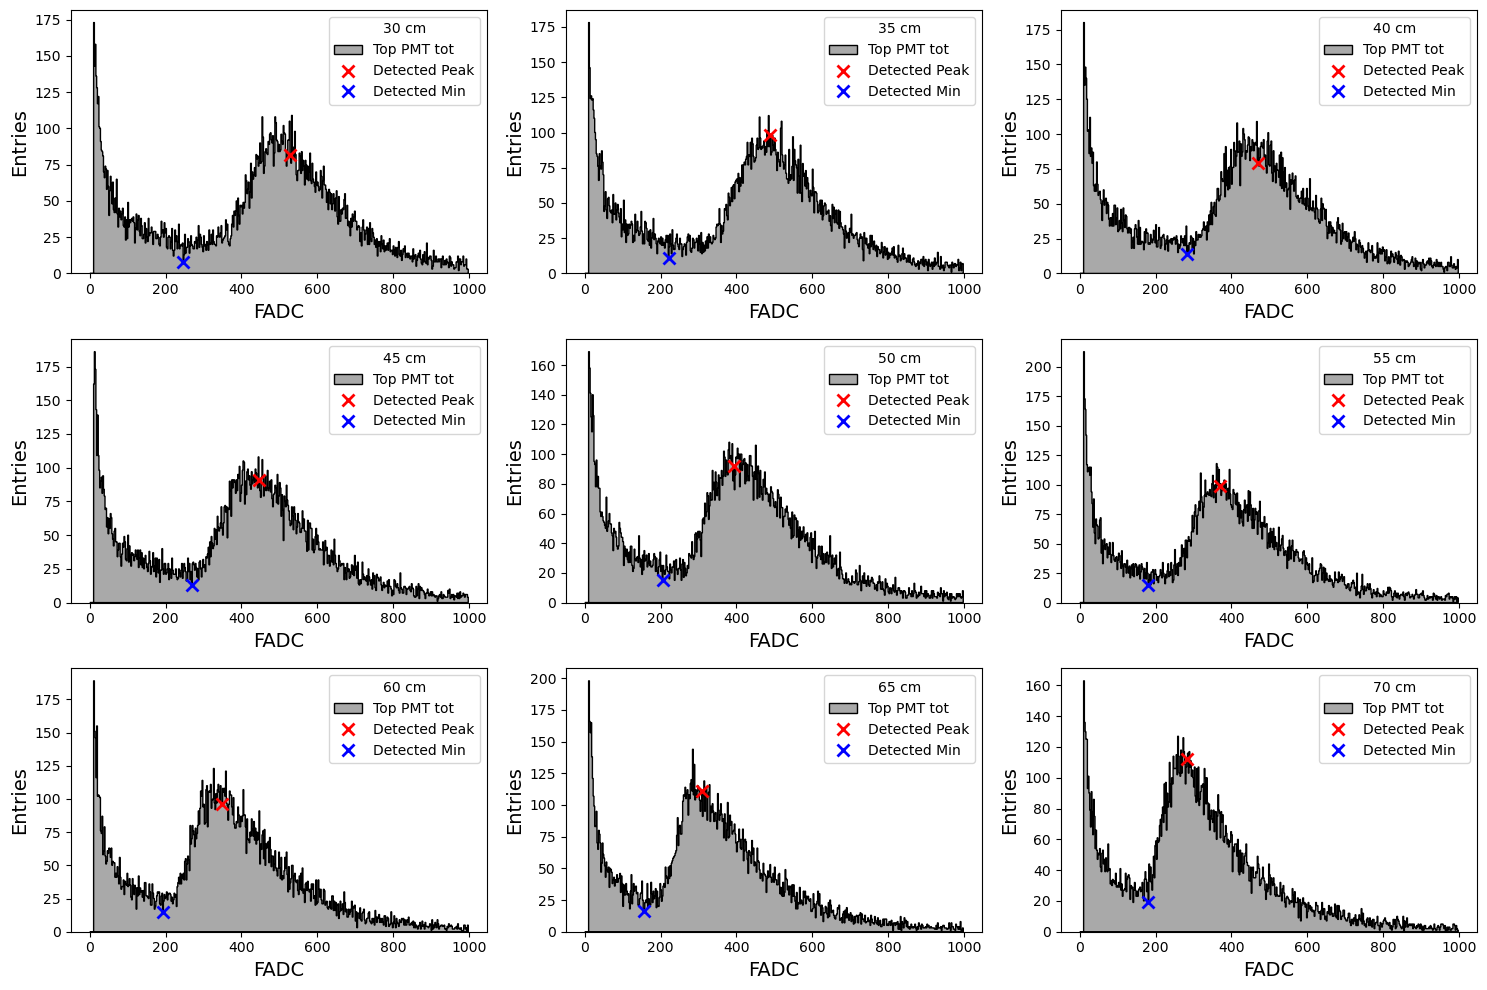

In [23]:
plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,1000,FADC_BIN_WIDTH)

leg_title = ['30 cm','35 cm','40 cm','45 cm','50 cm','55 cm','60 cm','65 cm','70 cm']

for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_pmt(input_folder+file,'pmt4_FADC', minnpe=10)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    i_peak_bin = int(fadc_peak_bin[i])
    i_min_bin = int(fadc_min_bin[i])

    print('Max coordinates (',fadc_bin_centers[i_peak_bin],', ',fadc_peak_entries[i],')')
    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    plt.plot(fadc_bin_centers[i_peak_bin], fadc_peak_entries[i], 'rx', label='Detected Peak', ms=8, mew=2)
    plt.plot(fadc_bin_centers[i_min_bin], fadc_min_entries[i], 'bx', label='Detected Min',ms=8, mew=2)

    plt.legend(title = leg_title[i])
    plt.yscale('linear')
    plt.xlabel('FADC',size=14)
    plt.ylabel('Entries',size=14)


plt.tight_layout()

Text(0, 0.5, 'Peak to dip ratio')

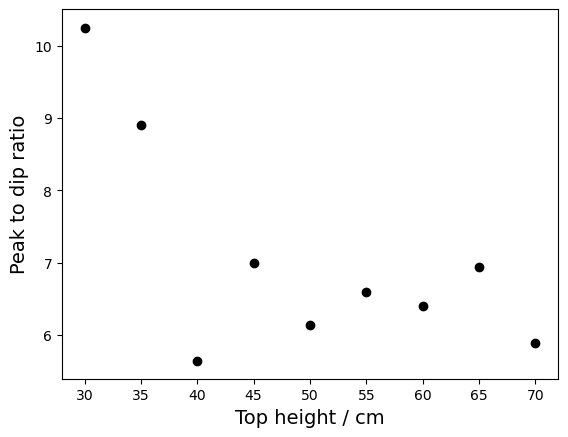

In [24]:

top_height = np.arange(30,75,5)
ratio = fadc_peak_entries / fadc_min_entries

plt.errorbar(top_height, ratio, yerr = ratio * rel_peak_err, fmt='o',markerfacecolor='black', markeredgecolor='black', ecolor = 'black')
plt.xlabel('Top height / cm',size=14)
plt.ylabel('Peak to dip ratio',size=14)